## 1. Modeling


In [3]:
import joblib
import optuna
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis

### 1.1 Model preparation

#### 1.1.1 Train-Test Split

In [6]:
data_cln = pd.read_csv(r"E:\Learning\1.AI-DS\Projects\Hyperparameter-Tuning-of-Machine-Learning\data\processed\data_cln1.csv")
x = data_cln.drop(columns="Outcome")
y = data_cln["Outcome"]

rs = 100     #set randome_state

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=rs, stratify=y)

#### 1.1.2 Feature Scaling

In [8]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_ = scaler.transform(x_train)
x_test_ = scaler.transform(x_test)

#### 1.1.3 Cross Vallidation

K-fold cross-validation is a powerful technique in machine learning, dividing the dataset into subsets and training on k-1 folds while testing on the remaining fold.

Repeated k-fold cross-validation extends this approach with multiple iterations, reducing variance and ensuring robust model evaluation. It aids in model selection, hyperparameter tuning, and mitigating overfitting, providing reliable estimates of generalization ability..

In [7]:
#from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

## What is the hyperparameter tuning?

* **Parameters** in a machine learning model are algorithm-produced variables that create predictions based on the training data.

* **Hyper-parameters**, on the other hand, are user-defined variables while building the model, controlling the learning process.

Hyperparameter optimization aims to find the best solution among all possibilities, optimizing the target value. Packages like GridSearchCV, RandomizedSearchCV, and Optuna assist in identifying the optimal hyperparameter combinations for our models. These techniques are referred to as hyperparameter tuning or optimization.

If we don't specify parameter values, default values are used, raising the question of how suitable they are for the dataset, which is crucial to consider during model building.

**Basic Techniques:**
* RandomizedSearchCV
* GridSearchCV

**Advanced Techniques:**
* Bayesian Optimization
* TPOT Classifier(Genetic Algorithm)
* Optuna
* etc

## Why Optuna?

Optuna is a versatile hyperparameter tuning library, designed to work with any machine learning or deep learning framework. It offers three key features for optimal hyperparameter optimization:

1. Eager search spaces: Automates the search for optimal hyperparameters.
2. State-of-the-art algorithms: Efficiently explores large parameter spaces and prunes unproductive trials for faster results.
3. Easy parallelization: Enables hyperparameter search across multiple threads or processes without code modification.

In this guide, we'll begin by using Optuna with sklearn, a user-friendly machine learning framework.

## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 1.2 KNN (K-Nearest Neighbors Algorithm)

In [9]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="accuracy").mean()

    return score

In [ ]:
# Creating and running our optimization

study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
study_knn.optimize(objective_knn, n_trials=500)

In [11]:
# Evaluating our Optuna Trial
print("Best trial:", study_knn.best_trial.number)
print("Best accuracy:", study_knn.best_trial.value)
print("Best hyperparameters:", study_knn.best_params)

Best trial: 11
Best accuracy: 0.8382232612507304
Best hyperparameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'manhattan', 'p': 50, 'algorithm': 'auto', 'leaf_size': 100}


              precision    recall  f1-score   support

           0       0.92      0.96      0.94        96
           1       0.91      0.84      0.88        51

    accuracy                           0.92       147
   macro avg       0.92      0.90      0.91       147
weighted avg       0.92      0.92      0.92       147



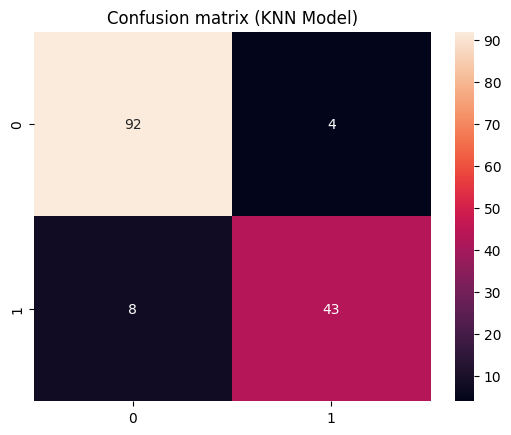

In [12]:
best_param_knn = study_knn.best_params
KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
y_pred_knn = KNN.predict(x_test_)

def display_results(y_test, y_pred, cm_title):
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
    print(classification_report(y_test,y_pred))
    
display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

In [14]:
#save models with outputs

joblib.dump(value = [study_knn,KNN,y_pred_knn,best_param_knn],
            filename = r"E:\Learning\1.AI-DS\Projects\Hyperparameter-Tuning-of-Machine-Learning\models\KNN.pkl")

['E:\\Learning\\1.AI-DS\\Projects\\Hyperparameter-Tuning-of-Machine-Learning\\models\\KNN.pkl']

### 1.3 Logistic Regression


In [15]:
# Creating an Objective Function

def objective_lr(trial):
    
    # Define hyperparameters
    param_logr = {'C' : trial.suggest_float("C", 0.001, 10.0, log=True),
    'solver' : trial.suggest_categorical('solver',["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
    'max_iter' : trial.suggest_int("max_iter", 1, 10000)
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr,random_state=rs)
    lr.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(lr, x_train_, y_train, cv=cv, scoring="accuracy").mean()

    return score

In [ ]:
# Creating and running our optimization

study_lr = optuna.create_study(direction='maximize',study_name = "logr")
study_lr.optimize(objective_lr, n_trials=500)

In [17]:
# Evaluating our Optuna Trial
print("Best trial:", study_lr.best_trial.number)
print("Best accuracy:", study_lr.best_trial.value)
print("Best hyperparameters:", study_lr.best_params)

Best trial: 44
Best accuracy: 0.7989596727060199
Best hyperparameters: {'C': 0.0031297386856363094, 'solver': 'liblinear', 'max_iter': 4388}


              precision    recall  f1-score   support

           0       0.90      0.83      0.86        96
           1       0.72      0.82      0.77        51

    accuracy                           0.83       147
   macro avg       0.81      0.83      0.82       147
weighted avg       0.84      0.83      0.83       147



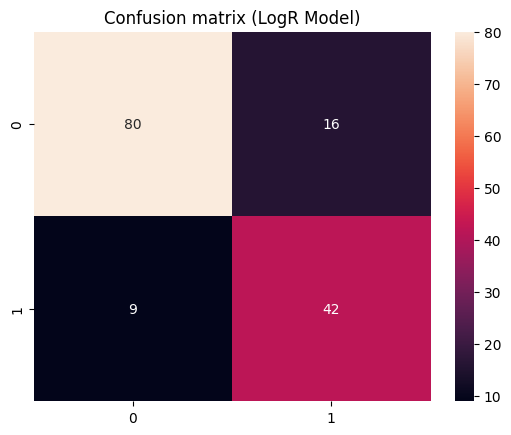

In [18]:
best_param_logr = study_lr.best_params
LR = LogisticRegression(**best_param_logr).fit(x_train_,y_train)
y_pred_lr = LR.predict(x_test_)
    
display_results(y_test, y_pred_lr, cm_title = "Confusion matrix (LogR Model)")